# Processing, saving and plotting netcdfs with xarray

This notebook has example code to access, process, save and plot netcdf files.

## First, load modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from nc_processing import *
from analysis import * 

%matplotlib inline

## Define the directory and filename from specifications

In [2]:
# define the data directory to search for files using lists
data_dir='/badc/cmip6/data/CMIP6/{project}/{centre}/{model}/{exp}/{run}/{domain}/{var}/gn/latest/'
# define the base of the filename for the output file(s) using lists, note this matches the file format in the data directory except for the date_4_file section and the missing .nc. 
out_base='{var}_{domain}_{model}_{exp}_{run}_gn_{time_range}' # all that's missing is a .nc but we can add that later.

let's find some files for the UKESM1 model

In [3]:
model='UKESM1-0-LL'
centre='MOHC'

var='tas'
domain='Amon'

exp='G6sulfur'
project='GeoMIP'

run='r1i1p1f2'

# Let's fill in the blanks in our directory structure with those variables
test_dir = data_dir.format(model=model, centre=centre, var=var, domain=domain, exp=exp, project=project, run=run)
# os.listdir just performs a normal "ls" command on the linux system with the text specified within the parentheses.
test_dir_files = os.listdir(test_dir)
print(test_dir_files)

['tas_Amon_UKESM1-0-LL_G6sulfur_r1i1p1f2_gn_202001-204912.nc', 'tas_Amon_UKESM1-0-LL_G6sulfur_r1i1p1f2_gn_205001-210012.nc']


great, there's two files in there!

## Let's open the file in xarray and see what we've got

In [4]:
# specify the file path to the second file in that directory (python counts from zero for array positions.)
fpath = test_dir + test_dir_files[1]
ds = xr.open_dataset(fpath)

Let's see what's inside

In [5]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192, time: 612)
Coordinates:
  * time       (time) object 2050-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            GeoMIP
    branch_method:          standard
    branch_time_in_child:   61200.0
    branch_time_in_parent:  61200.0
    creation_date:          2019-11-12T11:51:49Z
    cv_version:             6.2.37.5
    data_specs_version:     01.00.29
    experiment:             stratospheric sulfate aerosol injection to reduce...
    experiment_id:          G6sulfur
   

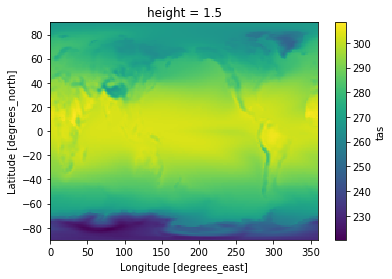

In [6]:
# let's plot the time mean of the data
ds.tas.mean("time").plot()

# Let's concatenate the two files into one

In [7]:
ds1 = xr.open_dataset(test_dir + test_dir_files[0])
ds2 = xr.open_dataset(test_dir + test_dir_files[1])

# add these datasets together concatenating along the time dimension.
ds_combined = xr.concat([ds1, ds2], 'time')

In [8]:
ds_combined.time # FYI leaving a variable on it's own at the end of a cell prints it, i.e. its the same as: print(ds_combined.time) 

<xarray.DataArray 'time' (time: 972)>
array([cftime.Datetime360Day(2020, 1, 16, 0, 0, 0, 0, 6, 16),
       cftime.Datetime360Day(2020, 2, 16, 0, 0, 0, 0, 1, 46),
       cftime.Datetime360Day(2020, 3, 16, 0, 0, 0, 0, 3, 76), ...,
       cftime.Datetime360Day(2100, 10, 16, 0, 0, 0, 0, 5, 286),
       cftime.Datetime360Day(2100, 11, 16, 0, 0, 0, 0, 0, 316),
       cftime.Datetime360Day(2100, 12, 16, 0, 0, 0, 0, 2, 346)], dtype=object)
Coordinates:
    height   float64 1.5
  * time     (time) object 2020-01-16 00:00:00 ... 2100-12-16 00:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

Great, it starts in 2020 and ends in 2100 so we've successfully joined those f

## Let's select a time-period

In [9]:
ds_70_100 = ds_combined.sel(time=slice('2070-01-01','2100-01-01'))
ds_70_100.time

<xarray.DataArray 'time' (time: 360)>
array([cftime.Datetime360Day(2070, 1, 16, 0, 0, 0, 0, 2, 16),
       cftime.Datetime360Day(2070, 2, 16, 0, 0, 0, 0, 4, 46),
       cftime.Datetime360Day(2070, 3, 16, 0, 0, 0, 0, 6, 76), ...,
       cftime.Datetime360Day(2099, 10, 16, 0, 0, 0, 0, 2, 286),
       cftime.Datetime360Day(2099, 11, 16, 0, 0, 0, 0, 4, 316),
       cftime.Datetime360Day(2099, 12, 16, 0, 0, 0, 0, 6, 346)], dtype=object)
Coordinates:
    height   float64 1.5
  * time     (time) object 2070-01-16 00:00:00 ... 2099-12-16 00:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

## Let's calculate seasonal means over the entire time period

In [10]:
ds_70_100_seasons = ds_70_100.groupby('time.season').mean(dim='time')

let's check that summer and winter look different

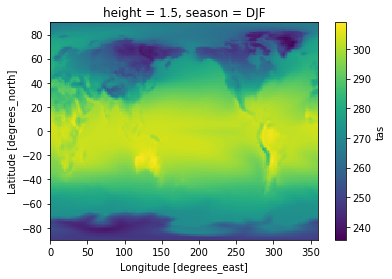

In [11]:
ds_70_100_seasons.tas.sel(season='DJF').plot()

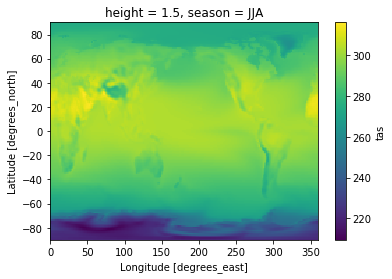

In [12]:
ds_70_100_seasons.tas.sel(season='JJA').plot()

Yup, Northern hemisphere summer is much warmer than the winter.

## NOTE - this simple approach only works as UKESM1 has 30-day months, to deal with months with different numbers of days a more complicated approach is needed: https://xarray.pydata.org/en/stable/examples/monthly-means.html

## NOTE - this fix has not been implemented in the functions below so unless another model you'd like to look at also has only 30-day months then the calculations will be off.

## Open the nc_processing.py file and read through the get_seasonal_mean_std and get_timeslice functions. These wrap up much of what I showed above into a simple to use package.

loading existing files tas_Amon_UKESM1-0-LL_G6sulfur_r1i1p1f2_gn_2070-01-01_2100-01-01 ANN


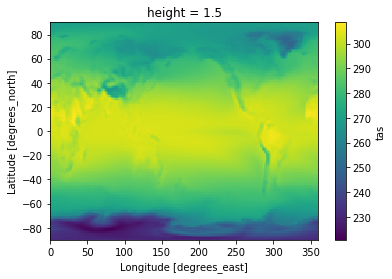

In [13]:
data_dir='/home/users/pjirvine/data/' # !!!!!!!!!!!!! CHANGE THIS !!!!!!!!!!!!!!!!!!

model='UKESM1-0-LL'
centre='MOHC'

var='tas'
domain='Amon'

exp='G6sulfur'
project='GeoMIP'

run='r1i1p1f2'

grid='gn'

season='ANN'
dates=['2070-01-01','2100-01-01']

time_files=1

# load the arguments into a list then... 
args=[season,dates,data_dir,model,centre,var,domain,exp,project,run,grid,time_files]
ds_mean, ds_std = get_seasonal_mean_std(*args) # ... unpack them into the function.

# Let's check the data looks right
ds_mean[var].plot()

# Let's try a simple anomaly

loading existing files tas_Amon_UKESM1-0-LL_G6solar_r1i1p1f2_gn_2070-01-01_2100-01-01 ANN


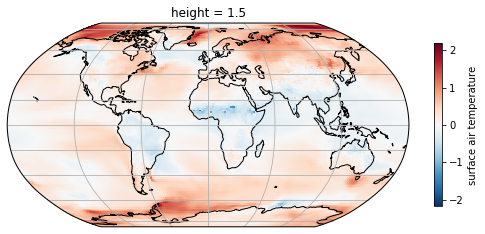

In [52]:
# load the arguments into a list then... 

# just change one variable, the experiment and leave the others as they are.
exp='G6solar'
args=[season,dates,data_dir,model,centre,var,domain,exp,project,run,grid,time_files]
ds_mean_2, ds_std_2 = get_seasonal_mean_std(*args) # ... unpack them into the function.

# Let's plot G6sulfur - Gsolar:
fig = plt.figure(figsize=(9,6)) # let's do a few things to make the plot look nice
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
(ds_mean[var] - ds_mean_2[var]).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5, 'label':'surface air temperature'})

## Right, let's check to see how much of that is statistically significant

The ttest_sub() function is in the analysis.py script. 

In [107]:
num_years = 30 # the t-test needs to know how long our sample is.

# ttest_sub returns a numpy array of P-values, where P is between 0 and 1. for 95% significance P is below 0.05
ttest_pvalue = ttest_sub(ds_mean[var],ds_std[var],num_years,ds_mean_2[var],ds_std_2[var],num_years)

# Let's put the ttest results into the same format as our xarray datasets
ds_ttest = xr.full_like(ds_mean, 0.0) # copy dataset format from ds_mean and set data values to 0.
ds_ttest.rename(name_dict={var:'p_value'}) # rename the variable to p_value
ds_ttest['p_value'] = (['lat','lon'],ttest_pvalue<0.05) # Fill in the blank values with our ttest results

### Let's recreate our anomaly plot, this time with stippling to indicate which areas are statistically significant.

Text(0.5, 1.0, 'G6sulfur - G6solar Temperature anomaly')

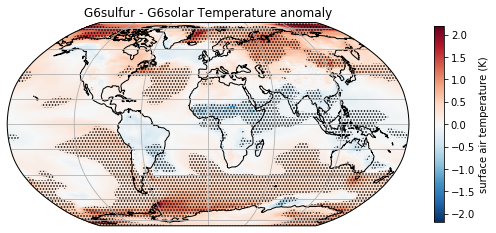

In [108]:
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
(ds_mean[var] - ds_mean_2[var]).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.6, 'label':'surface air temperature (K)'})
cf = ds_ttest['p_value'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=[0,0.05], hatches=["","...."], alpha=0, add_colorbar=False) # cbar_kwargs={'shrink': 0.0})
ax.set_title('G6sulfur - G6solar Temperature anomaly')

## Only the hatched areas are statistically significant

### this is the standard convention but it covers up the most relevant data, so let's reverse it so statistically significant places are unstippled.

Text(0.5, 1.0, 'G6sulfur - G6solar Temperature anomaly')

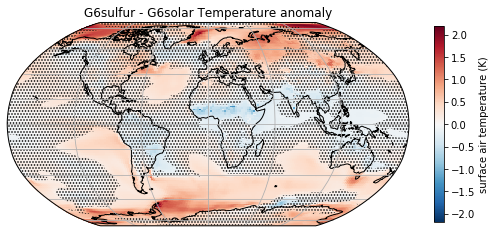

In [94]:
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
(ds_mean[var] - ds_mean_2[var]).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.6, 'label':'surface air temperature (K)'})
cf = ds_ttest['p_value'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=[0,0.05], hatches=["....",""], alpha=0, add_colorbar=False) # cbar_kwargs={'shrink': 0.0})
ax.set_title('G6sulfur - G6solar Temperature anomaly')

# Let's find the global-mean temperature and land-mean temperature

In [15]:
# Use the get_fixed() function to return the gridcell area and land fraction for the model we want.
ds_area, ds_land = get_fixed('MOHC','UKESM1-0-LL','r1i1p1f2') 
# NOTE - to do this for another model, you'll need to look up the run number used in the piControl experiment which stores the fx variables.
# search on CEDA archive for "areacella" and "<MODEL NAME>" and it should show you.

In [95]:
# Let's see what's in the area dataset 
ds_area['areacella']

<xarray.DataArray 'areacella' (lat: 144, lon: 192)>
array([[3.161191e+08, 3.161191e+08, 3.161191e+08, ..., 3.161191e+08,
        3.161191e+08, 3.161191e+08],
       [9.482093e+08, 9.482093e+08, 9.482093e+08, ..., 9.482093e+08,
        9.482093e+08, 9.482093e+08],
       [1.579848e+09, 1.579848e+09, 1.579848e+09, ..., 1.579848e+09,
        1.579848e+09, 1.579848e+09],
       ...,
       [1.579848e+09, 1.579848e+09, 1.579848e+09, ..., 1.579848e+09,
        1.579848e+09, 1.579848e+09],
       [9.482093e+08, 9.482093e+08, 9.482093e+08, ..., 9.482093e+08,
        9.482093e+08, 9.482093e+08],
       [3.161191e+08, 3.161191e+08, 3.161191e+08, ..., 3.161191e+08,
        3.161191e+08, 3.161191e+08]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
Attributes:
    standard_name:  cell_area
    long_name:      Grid-Cell Area for Atmospheric Grid Variables
    co

You can see that all values on the same latitude are the same, which makes sense.

In [98]:
# What's the total area of this model:
ds_area['areacella'].sum()

<xarray.DataArray 'areacella' ()>
array(5.101011e+14, dtype=float32)

Great! 5.1*10^14 is the area of the earth.

In [97]:
# Let's see what's in the land fraction dataset 
ds_land['sftlf']

<xarray.DataArray 'sftlf' (lat: 144, lon: 192)>
array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    type     |S4 ...
Attributes:
    standard_name:   land_area_fraction
    long_name:       Percentage of the grid  cell occupied by land (including...
    comment:         Please express 'X_area_fraction' as the percentage of ho...
    units:           %
    original_name:   mo: (stash: m01s00i505)
    original_units:  1
    history:         2019-07-04T21:31:24Z altered by CMOR: Converted units fr...
    cell_methods:    area: mean
    cell_measur

land fraction is recorded as a percentage so has values between 0 and 100. NOTE - the array preview shows the first and last 3 rows and columns in the array, starting from the south pole (100% land) and ending at the north pole (100% water).

### Let's calculate the global-mean temperature in the G6sulfur experiment

In [118]:
# Let's define a data array for the area weight of the gridcells
da_weight = ds_area['areacella'] / ds_area['areacella'].sum()
da_weight = da_weight.rename(new_name_or_name_dict='area_weight')
da_weight

<xarray.DataArray 'area_weight' (lat: 144, lon: 192)>
array([[6.197184e-07, 6.197184e-07, 6.197184e-07, ..., 6.197184e-07,
        6.197184e-07, 6.197184e-07],
       [1.858865e-06, 1.858865e-06, 1.858865e-06, ..., 1.858865e-06,
        1.858865e-06, 1.858865e-06],
       [3.097128e-06, 3.097128e-06, 3.097128e-06, ..., 3.097128e-06,
        3.097128e-06, 3.097128e-06],
       ...,
       [3.097128e-06, 3.097128e-06, 3.097128e-06, ..., 3.097128e-06,
        3.097128e-06, 3.097128e-06],
       [1.858865e-06, 1.858865e-06, 1.858865e-06, ..., 1.858865e-06,
        1.858865e-06, 1.858865e-06],
       [6.197184e-07, 6.197184e-07, 6.197184e-07, ..., 6.197184e-07,
        6.197184e-07, 6.197184e-07]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1

In [119]:
#looks good let's check that it sums to 1.
da_weight.sum()

<xarray.DataArray 'area_weight' ()>
array(1., dtype=float32)

Perfect. Now let's calculate our global-mean temperature for G6sulfur

In [121]:
# multiply each temperature value with it's corresponding fraction of total area, then sum to find the global mean.
(ds_mean[var]*da_weight).sum() - 273.15 # convert from K to C.

<xarray.DataArray ()>
array(17.318323)
Coordinates:
    height   float64 1.5

Great, we've got a global-mean temperature of 17.3C which sounds about right (global-mean temp in the real world was ~13C before pre-industrial, and models are usually around that and we've had some warming in this scenario.)

## Let's calculate the land-mean temperature

First let's get the land area

In [123]:
# land area = gricell area * land fraction ([0-100] * 0.01)
da_land_area = ds_area['areacella'] * ds_land['sftlf'] * 0.01 
da_land_area.sum()

<xarray.DataArray ()>
array(1.469947e+14, dtype=float32)
Coordinates:
    type     |S4 ...

Great, the land area looks right at about 30% of the global area.

In [124]:
# Now let's create a land area weighting
da_land_weight = da_land_area / da_land_area.sum()
da_land_weight.sum()

<xarray.DataArray ()>
array(1., dtype=float32)
Coordinates:
    type     |S4 b'land'

Great, this also sums to 1.

Now let's calculate the land-mean temperature

In [126]:
(ds_mean[var]*da_land_weight).sum() - 273.15 # convert from K to C.

<xarray.DataArray ()>
array(12.691644)
Coordinates:
    height   float64 1.5
    type     |S4 b'land'

Hmm, 12.7C is quite a lot lower. does that sound right? Let's plot the temperature and see.

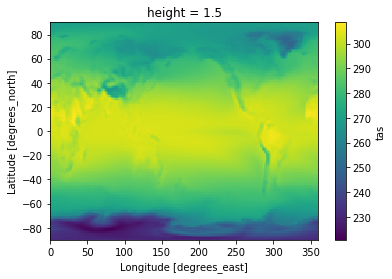

In [127]:
ds_mean[var].plot()

Yes it does. Look how cold antarctica is, and look how much of the yellow (warm) area is ocean.